Dataset loaded successfully
Train shape: (2625, 3)
Validation shape: (3589, 3)
Test shape: (3589, 3)
train _X shape: {},  train _Y shape: (2625, 48, 48, 1)
validation _X shape: {},  validation _Y shape: (3589, 48, 48, 1)
test _X shape: {},  test _Y shape: (3589, 48, 48, 1)
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 48, 48, 64)        640       
                                                                 
 conv2d_7 (Conv2D)           (None, 48, 48, 64)        36928     
                                                                 
 batch_normalization_5 (Batc  (None, 48, 48, 64)       256       
 hNormalization)                                                 
                                                                 
 activation_3 (Activation)   (None, 48, 48, 64)        0         
                                            

KeyboardInterrupt: 

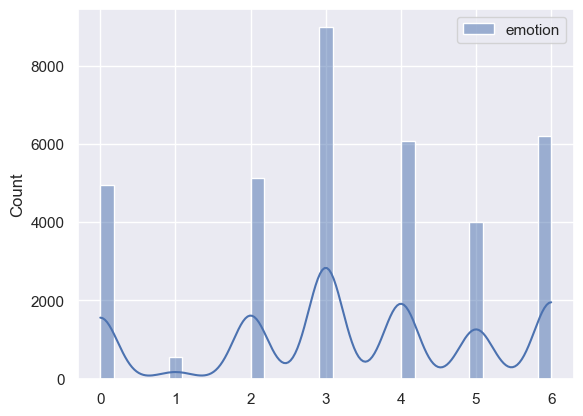

In [3]:
#Import ML required packages
import numpy as np
import pandas as pd 
import keras
from keras.utils import to_categorical
#Import Libraries before model creation
from keras.models import Sequential
from keras.layers import Conv2D,MaxPooling2D,BatchNormalization
from keras.layers import Dense,Dropout,Activation,Flatten
from keras.losses import categorical_crossentropy
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix,classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import xml.etree.ElementTree as ET
# %matplotlib inline

#Load and Read the dataset
emotion_data = pd.read_csv('D:/Major Pro/fer2013.csv')
print('Dataset loaded successfully')

emotion_data.head()

emotion_data.tail()

emotion_data.Usage.value_counts()

# Pull out dataset in different categories
data_train = emotion_data[emotion_data['Usage'] == 'Training'].copy()
data_val = emotion_data[emotion_data['Usage'] == 'PublicTest'].copy()
data_test = emotion_data[emotion_data['Usage'] == 'PrivateTest'].copy()

# Shuffle the training data
data_train = data_train.sample(frac=1, random_state=42)

# Get the first 'desired_training_size' samples for training
data_train = data_train.head(2625)

# Print the updated dataset shapes
print('Train shape: {}\nValidation shape: {}\nTest shape: {}'.format(data_train.shape, data_val.shape, data_test.shape))


#Initialize Parameters
num_classes = 7
epochs = 50
batch_size = 16
num_features = 32
width, height = 48,48

emotion_data.shape

emotion_data.describe()

#checking for missing values
emotion_data.isna().sum()

sns.set_theme(style='darkgrid', palette='deep', font='sans-serif', font_scale=1)
sns.histplot(data= emotion_data,kde = True)

#Data Preprocessing
#Perform CRNO (CRNO stands for Convert,Reshape, Normalize, one-hot-encoding)
def CRNO(df,dataName):
    df['pixels'] = df['pixels'].apply(lambda pixel_sequence: [int(pixel) for pixel in pixel_sequence.split()])
    data_X = np.array(df['pixels'].tolist(),dtype='float32').reshape(-1,width,height,1)/255.0
    data_Y = to_categorical(df['emotion'],num_classes)
    print(dataName, "_X shape: {}, ", dataName, "_Y shape: {}".format(data_X.shape, data_Y.shape))
    return data_X,data_Y

train_X,train_Y = CRNO(data_train,'train')
val_X,val_Y = CRNO(data_val,'validation')
test_X,test_Y = CRNO(data_test,'test')

#Build the model
model = Sequential()
#Module1 conv<<conv<<batchnorm<<relu<<maxpooling<<dropout
model.add(Conv2D(2*num_features,kernel_size=(3,3),padding='same',data_format='channels_last',input_shape=(width, height, 1)))
model.add(Conv2D(2*num_features,kernel_size=(3,3),padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D())
model.add(Dropout(rate=0.2))
#Module2 conv<<conv<<batchnorm<<relu<<maxpool<<dropout
model.add(Conv2D(2*2*num_features,kernel_size=(3,3),padding='same'))
model.add(Conv2D(2*2*num_features,kernel_size=(3,3),padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D())
model.add(Dropout(rate=0.2))
#Module3 conv<<conv<<batchnorm<<relu<<maxpool<<dropout
model.add(Conv2D(2*2*2*num_features,kernel_size=(1,1),padding='same'))
model.add(Conv2D(2*2*2*num_features,kernel_size=(1,1),strides=(2,2)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D())
model.add(Dropout(rate=0.2))
#Module4 fc<<batchnorm<<fc<<batchnorm<<dropout<<softmax
model.add(Flatten())
model.add(Dense(units=128))
model.add(BatchNormalization())
model.add(Dense(units=128))
model.add(BatchNormalization())
model.add(Dropout(rate=0.2))
model.add(Dense(num_classes,activation='softmax'))

model.compile(loss='categorical_crossentropy',optimizer=Adam(learning_rate=0.001,beta_1=0.9,beta_2=0.999),metrics=['accuracy'])
model.summary()

#Training the model
es = EarlyStopping(monitor='val_loss', patience = 10, mode = 'min', restore_best_weights=True)

history = model.fit(train_X,train_Y,batch_size=batch_size,epochs=100,verbose=2,callbacks=[es],validation_split=0,validation_data=(val_X,val_Y),shuffle=True)

